In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans

with open('yet-another.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

dataset = pd.read_csv('final_1102022.csv')

# if we get a tuple of record_id, cluster, unpack it and merge (e.g. yet-another.pkl)
if type(cluster_labels) is tuple:
    dataset = dataset.rename(columns={'Unnamed: 0': 'record_id'})
    cluster_labels = pd.DataFrame(zip(cluster_labels[0], cluster_labels[1]), columns=['record_id', 'cluster_id'])
    dataset = dataset.merge(cluster_labels, on='record_id')
    
else: # we just got a list of clusters, hope it maches up
    dataset['cluster_id'] = cluster_labels

dataset = dataset.loc[dataset['GM%'] >= -10]
dataset = dataset.loc[dataset['GM%'] <= 1]

In [2]:
dataset.shape

(1100264, 28)

In [3]:
## DROP WHERE # OF DATAPOINTS < 5 (cannot cluster at all)
cluster_sizes = dataset.groupby(['cluster_id']).cluster_id.size()
bad_clusters = cluster_sizes.where(lambda x: x < 500).dropna()
print("dropping clusters: ", bad_clusters.index)

dataset = dataset.loc[~dataset['cluster_id'].isin(bad_clusters.index)]

clusters = dataset.cluster_id.unique()
print("has clusters: ", clusters, " len = ", len(clusters))

dropping clusters:  Int64Index([3, 6, 9, 24, 39, 64, 72, 75], dtype='int64', name='cluster_id')
has clusters:  [86 15 74 78 40  4 59 23  7 63 52 68 84 80 13 65 58 21  8 85 81 34 42 55
 82 41 66 45 79 77 38 53 16 29 87 50 27 37 14  2 56 28 54  1 51 76 17 83
 60 62  0 33 32 57 61 35 47 11 44 69 18 26 71 49 22 46 67 12 30 10 31 19
 25  5 48 20 36 43 73 70]  len =  80


In [4]:
#kmeans = [KMeans(n_clusters=5).fit(np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)) for cid in cluster_labels]

kmeans_objs = [] # list of tuples - cluster id, corresponding KMeans obj
for cid in clusters:
    data = np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)
    #print("training KMeans on {} datapoints for cluster {}".format(data.shape[0], cid))
    kmeans = KMeans(n_clusters=5).fit(data)
    kmeans_objs.append((cid, kmeans))

In [5]:
# dataset diff between max and min GM%
print("in entire dataset, gm% range: ", dataset['GM%'].max() - dataset['GM%'].min())

dgb = dataset.groupby(['cluster_id'])
gm_ranges = (dgb['GM%'].max() - dgb['GM%'].min())
print(gm_ranges)



in entire dataset, gm% range:  11.0
cluster_id
0     10.237500
1     10.750000
2     10.894762
4      8.807537
5      6.684838
        ...    
83     9.400000
84    10.967439
85    10.339923
86    10.369550
87     7.778887
Name: GM%, Length: 80, dtype: float64


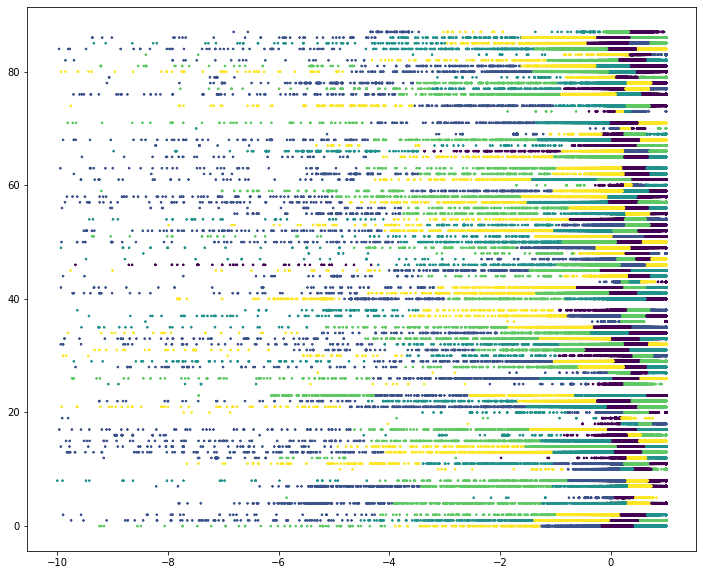

In [6]:
# assign price grades for each cluster centroid/labels
import matplotlib.pyplot as plt
for cid, kmeans in kmeans_objs:
    dataset.loc[dataset.cluster_id == cid, 'price_grade_cluster_ind'] = kmeans.labels_

dataset['price_grade_cluster_ind'] = dataset['price_grade_cluster_ind'].astype(int)


fig = plt.gcf()
fig.set_size_inches(12, 10)

i = 0
for cid in clusters:
    data = dataset.loc[dataset.cluster_id == cid]
    
    plt.scatter(data['GM%'], [cid]*data.shape[0], marker='x', s=3,c=data['price_grade_cluster_ind'])
#fig.savefig('test2png.png', dpi=200)


In [7]:
clusters_df = pd.DataFrame(clusters, columns=['cluster_id'])
clusters_df.set_index('cluster_id')

for cid, kmeans in kmeans_objs:
    label_center = sorted(zip(range(5), kmeans.cluster_centers_), key=lambda el: el[1], reverse=True)
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_label'] = label_center[0][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_label'] = label_center[1][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_label'] = label_center[2][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_label'] = label_center[3][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_label'] = label_center[4][0]
    
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_center'] = label_center[0][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_center'] = label_center[1][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_center'] = label_center[2][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_center'] = label_center[3][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_center'] = label_center[4][1]
    
clusters_df = clusters_df.astype({'a_label': int, 'b_label': int, 'c_label': int, 'd_label': int, 'f_label': int})

In [8]:
#assign 'price_grade' column to dataset

for cid in clusters:
    a_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['a_label'])
    b_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['b_label'])
    c_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['c_label'])
    d_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['d_label'])
    f_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['f_label'])

    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == a_label_for_cluster), 'price_grade'] = 'A'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == b_label_for_cluster), 'price_grade'] = 'B'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == c_label_for_cluster), 'price_grade'] = 'C'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == d_label_for_cluster), 'price_grade'] = 'D'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == f_label_for_cluster), 'price_grade'] = 'F'

In [9]:
price_grade_sizes = dataset[['cluster_id', 'price_grade']].groupby(['cluster_id', 'price_grade'], as_index=False).size()
a_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='A'][['cluster_id', 'size']].rename(columns={'size':'a_size'})
b_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='B'][['cluster_id', 'size']].rename(columns={'size':'b_size'})
c_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='C'][['cluster_id', 'size']].rename(columns={'size':'c_size'})
d_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='D'][['cluster_id', 'size']].rename(columns={'size':'d_size'})
f_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='F'][['cluster_id', 'size']].rename(columns={'size':'f_size'})

clusters_df = clusters_df.merge(a_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(b_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(c_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(d_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(f_price_grade_sizes, on=['cluster_id'])

In [10]:

cluster_sizes = dataset.groupby(['cluster_id'], as_index=False).cluster_id.size().rename(columns={'size': 'cluster_size'})
clusters_df = clusters_df.merge(cluster_sizes, on=['cluster_id'])

In [11]:
clusters_df['Adata%'] = 100.0*(clusters_df['a_size']/clusters_df['cluster_size']).round(4)
clusters_df['Bdata%'] = 100.0*(clusters_df['b_size']/clusters_df['cluster_size']).round(4)
clusters_df['Cdata%'] = 100.0*(clusters_df['c_size']/clusters_df['cluster_size']).round(4)
clusters_df['Ddata%'] = 100.0*(clusters_df['d_size']/clusters_df['cluster_size']).round(4)
clusters_df['Fdata%'] = 100.0*(clusters_df['f_size']/clusters_df['cluster_size']).round(4)
clusters_df = clusters_df.sort_values(by='cluster_id')


In [12]:
clusters_df

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,...,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
50,0,2,0,1,4,3,0.690563,0.134335,-0.464618,-2.094017,...,10288,1001,171,50,14167,18.75,72.62,7.07,1.21,0.35
43,1,3,0,4,2,1,0.721438,0.291380,-0.328134,-2.467548,...,14444,2348,202,63,23519,27.48,61.41,9.98,0.86,0.27
39,2,2,0,4,3,1,0.878927,0.402728,-0.040115,-1.932892,...,10049,2283,139,30,15949,21.62,63.01,14.31,0.87,0.19
5,4,0,4,2,3,1,0.987076,0.475495,0.083326,-2.594028,...,3209,2401,231,235,12214,50.25,26.27,19.66,1.89,1.92
73,5,4,0,1,2,3,0.624770,0.221452,-0.109549,-1.702375,...,639,346,7,1,1072,7.37,59.61,32.28,0.65,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,83,1,0,4,2,3,0.994288,0.470425,0.223783,-2.047260,...,1288,875,15,2,4275,49.01,30.13,20.47,0.35,0.05
12,84,4,0,3,2,1,0.677773,0.267454,-0.376691,-2.417759,...,10672,1822,191,46,17781,28.40,60.02,10.25,1.07,0.26
19,85,3,1,0,4,2,0.913203,0.480211,0.175569,-1.040110,...,10430,6702,468,75,22684,22.08,45.98,29.55,2.06,0.33
0,86,3,0,4,2,1,0.585478,0.114315,-0.644349,-2.567944,...,9261,570,105,44,13030,23.41,71.07,4.37,0.81,0.34


In [13]:

with pd.option_context('display.max_rows', None):
    display(clusters_df[['cluster_id', 'Adata%', 'Bdata%', 'Cdata%', 'Ddata%', 'Fdata%']])

,cluster_id,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
50,0,18.75,72.62,7.07,1.21,0.35
43,1,27.48,61.41,9.98,0.86,0.27
39,2,21.62,63.01,14.31,0.87,0.19
5,4,50.25,26.27,19.66,1.89,1.92
73,5,7.37,59.61,32.28,0.65,0.09
8,7,56.48,21.34,17.97,2.06,2.14
18,8,22.36,56.54,19.91,1.07,0.12
69,10,14.54,26.25,31.26,27.54,0.42
57,11,45.49,29.43,22.95,1.28,0.85
67,12,15.49,48.77,32.01,0.64,3.09


In [14]:
gm_ranges = dataset.groupby(['cluster_id', 'price_grade'], as_index=False).agg({'GM%': ['min', 'max']})
gm_ranges.columns = ['cluster_id', 'price_grade', 'gm%min', 'gm%max']
clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'A'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Agm%min', 'gm%max': 'Agm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'B'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Bgm%min', 'gm%max': 'Bgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'C'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Cgm%min', 'gm%max': 'Cgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'D'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Dgm%min', 'gm%max': 'Dgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'F'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Fgm%min', 'gm%max': 'Fgm%max'})

In [15]:
clusters_df['total_pricing_width'] = clusters_df['Agm%max'] - clusters_df['Fgm%min']
clusters_df['Apricing_width%'] = (100.0*(clusters_df['Agm%max'] - clusters_df['Agm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Bpricing_width%'] = (100.0*(clusters_df['Bgm%max'] - clusters_df['Bgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Cpricing_width%'] = (100.0*(clusters_df['Cgm%max'] - clusters_df['Cgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Dpricing_width%'] = (100.0*(clusters_df['Dgm%max'] - clusters_df['Dgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Fpricing_width%'] = (100.0*(clusters_df['Fgm%max'] - clusters_df['Fgm%min'])/clusters_df['total_pricing_width']).round(2)

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(clusters_df)

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,f_center,a_size,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%,Agm%min,Agm%max,Bgm%min,Bgm%max,Cgm%min,Cgm%max,Dgm%min,Dgm%max,Fgm%min,Fgm%max,total_pricing_width,Apricing_width%,Bpricing_width%,Cpricing_width%,Dpricing_width%,Fpricing_width%
0,0,2,0,1,4,3,0.690563,0.134335,-0.464618,-2.094017,-5.902633,2657,10288,1001,171,50,14167,18.75,72.62,7.07,1.21,0.35,0.412899,1.000000,-0.164706,0.412371,-1.272973,-0.165472,-3.888889,-1.286266,-9.237500,-4.082759,10.237500,5.73,5.64,10.82,25.42,50.35
1,1,3,0,4,2,1,0.721438,0.291380,-0.328134,-2.467548,-6.745737,6462,14444,2348,202,63,23519,27.48,61.41,9.98,0.86,0.27,0.506417,1.000000,-0.018333,0.506381,-1.393007,-0.018519,-4.514773,-1.413704,-9.750000,-4.682609,10.750000,4.59,4.88,12.79,28.85,47.14
2,2,2,0,4,3,1,0.878927,0.402728,-0.040115,-1.932892,-6.553846,3448,10049,2283,139,30,15949,21.62,63.01,14.31,0.87,0.19,0.640966,1.000000,0.181452,0.640790,-0.981570,0.181282,-4.156667,-0.998519,-9.894762,-4.266667,10.894762,3.30,4.22,10.67,28.99,51.66
3,4,0,4,2,3,1,0.987076,0.475495,0.083326,-2.594028,-5.248602,6138,3209,2401,231,235,12214,50.25,26.27,19.66,1.89,1.92,0.731942,1.000000,0.279597,0.730416,-1.229058,0.279225,-3.910764,-1.256769,-7.807537,-3.953966,8.807537,3.04,5.12,17.12,30.13,43.75
4,5,4,0,1,2,3,0.624770,0.221452,-0.109549,-1.702375,-5.856402,79,639,346,7,1,1072,7.37,59.61,32.28,0.65,0.09,0.442628,0.828436,0.057952,0.419573,-0.753537,0.053869,-2.474710,-1.180684,-5.856402,-5.856402,6.684838,5.77,5.41,12.08,19.36,0.00
5,7,0,4,2,3,1,0.989514,0.492624,0.121463,-2.264332,-4.634863,8266,3123,2630,302,313,14634,56.48,21.34,17.97,2.06,2.14,0.741190,1.000000,0.307161,0.740468,-1.060065,0.306912,-3.433679,-1.079932,-8.211229,-3.458833,9.211229,2.81,4.70,14.84,25.55,51.59
6,8,0,4,1,3,2,0.910280,0.437398,0.093083,-1.647566,-6.975153,4909,12415,4373,235,27,21959,22.36,56.54,19.91,1.07,0.12,0.673960,1.000000,0.265286,0.673833,-0.767223,0.265139,-4.169048,-0.791952,-10.000000,-4.406789,11.000000,2.96,3.71,9.39,30.70,50.85
7,10,3,0,2,1,4,0.981791,0.529228,0.297412,0.029601,-1.714216,1442,2603,3100,2731,42,9918,14.54,26.25,31.26,27.54,0.42,0.756098,1.000000,0.413333,0.755102,0.163934,0.413228,-0.768473,0.163121,-4.892857,-0.875000,5.892857,4.14,5.80,4.23,15.81,68.18
8,11,0,3,1,2,4,0.984787,0.420879,0.058972,-2.120653,-4.706477,6284,4066,3170,177,118,13815,45.49,29.43,22.95,1.28,0.85,0.703350,1.000000,0.240036,0.702513,-1.028275,0.239855,-3.385572,-1.055341,-7.657320,-3.459198,8.657320,3.43,5.34,14.65,26.92,48.49
9,12,2,4,0,3,1,0.922346,0.400335,0.170783,-5.153473,-7.102793,512,1612,1058,21,102,3305,15.49,48.77,32.01,0.64,3.09,0.663824,1.000000,0.285714,0.661316,-1.981150,0.284464,-5.971979,-2.800000,-9.161370,-6.231306,10.161370,3.31,3.70,22.30,31.22,28.84
